In [1]:
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.optim import Adam,SGD

from torch.utils.data import random_split, DataLoader

import torchvision
from torchvision.datasets import CIFAR10,CIFAR100
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(0))

cuda
0
1
GeForce RTX 3090


In [3]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
ds10=CIFAR10(root="./data",download=True,train=True,transform=transform)
ts10=CIFAR10(root="./data",download=True,train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
tr10,vs10,_=random_split(ds10,[10000,10000,30000],torch.manual_seed(1))

In [7]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=3*32*32,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=10)
            )
        
    def forward(self,in_):
        in_=self.layer(in_)
        return in_

mlp=MyMLP().to(device)

In [8]:
training_epochs=20
batch_size=4

In [9]:
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(mlp.parameters(),lr=0.001, momentum=0.9)

In [10]:
tr10_loader=DataLoader(dataset=tr10,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True)

vs10_loader=DataLoader(dataset=vs10,
                      batch_size=batch_size,
                      shuffle=False)

In [11]:
start=time.time()

training_loss_history=[]
validation_loss_history=[]

for epoch in range(training_epochs):
    #mlp.train()
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr10_loader:
        X=X.to(device)
        y=y.to(device)
        X=X.view(-1,3*32*32)
        
        opt.zero_grad()
        output=mlp(X) 
        #print(output)
        #print(y)
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
        training_loss+=cost.item()
        
    with torch.no_grad():
        #mlp.eval()
        for X,y in vs10_loader:
            X=X.to(device)
            y=y.to(device)
            X=X.view(-1,3*32*32)
            output=mlp(X)
            cost=obj(output,y)
            
            validation_loss+=cost.item()
            
    #if epoch==39:        
    #    sch.step()        
    training_loss_history.append(training_loss/(10000/batch_size))
    validation_loss_history.append(validation_loss/(10000/batch_size))
    print("[ Epoch: ",epoch+1," loss :",training_loss/(10000/batch_size)," validation :",validation_loss/(10000/batch_size),"]")
    
print("Time :",time.time()-start)

[ Epoch:  1  loss : 2.142202998590469  validation : 1.9548051395893098 ]
[ Epoch:  2  loss : 1.8110411031484603  validation : 1.7190808244943618 ]
[ Epoch:  3  loss : 1.6424328967452049  validation : 1.6808160583853722 ]
[ Epoch:  4  loss : 1.525046788418293  validation : 1.631696072101593 ]
[ Epoch:  5  loss : 1.4141672356963157  validation : 1.5704778788089753 ]
[ Epoch:  6  loss : 1.3179607893288134  validation : 1.5787085073530673 ]
[ Epoch:  7  loss : 1.2209821961641312  validation : 1.5630721148490905 ]
[ Epoch:  8  loss : 1.132253079378605  validation : 1.6147253142267466 ]
[ Epoch:  9  loss : 1.0331394112154841  validation : 1.7459957604408265 ]
[ Epoch:  10  loss : 0.9463169378906489  validation : 1.7741660263508559 ]
[ Epoch:  11  loss : 0.8706237489165738  validation : 1.7318455650910736 ]
[ Epoch:  12  loss : 0.769515979674831  validation : 1.8389368786282838 ]
[ Epoch:  13  loss : 0.7153870706221088  validation : 1.8085272461742163 ]
[ Epoch:  14  loss : 0.6298182259522378

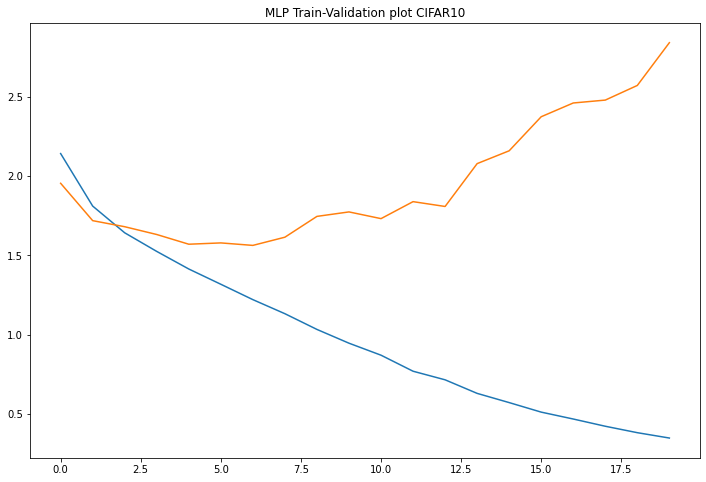

In [25]:
plt.figure(figsize=(12,8))
plt.plot(training_loss_history)
plt.plot(validation_loss_history)
plt.title("MLP Train-Validation plot CIFAR10")
plt.savefig("MLP Train-Validation plot CIFAR10.png")

In [14]:
ts10_loader=DataLoader(dataset=ts10,
                      batch_size=batch_size,
                      shuffle=False)

In [15]:
mlp=MyMLP().to(device)
training_epochs=7
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(mlp.parameters(),lr=0.001, momentum=0.9)

In [16]:
start=time.time()

for epoch in range(training_epochs):
    #mlp.train()
    
    for X,y in tr10_loader:
        X=X.to(device)
        y=y.to(device)
        X=X.view(-1,3*32*32)
        
        opt.zero_grad()
        output=mlp(X) 
        #print(output)
        #print(y)
        cost=obj(output,y)
        cost.backward()
        opt.step()

print("Time :",time.time()-start)

Time : 45.45531916618347


In [18]:
start=time.time()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in ts10_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images=images.view(-1,3*32*32)
        outputs = mlp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy :',(100 * correct / total))
print("Time :",time.time()-start)

Accuracy : 46.51
Time : 3.580897569656372


In [19]:
ds100=CIFAR100(root="./data",download=True,train=True,transform=transform)
ts100=CIFAR100(root="./data",download=True,train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
tr100,vs100,_=random_split(ds100,[10000,10000,30000],torch.manual_seed(1))

In [21]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=3*32*32,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=100)
            )
        
    def forward(self,in_):
        in_=self.layer(in_)
        return in_

mlp=MyMLP().to(device)

In [22]:
mlp=MyMLP().to(device)
training_epochs=20
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(mlp.parameters(),lr=0.001, momentum=0.9)

In [23]:
tr100_loader=DataLoader(dataset=tr100,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True)

vs100_loader=DataLoader(dataset=vs100,
                      batch_size=batch_size,
                      shuffle=False)

In [24]:
start=time.time()

training_loss_history_=[]
validation_loss_history_=[]

for epoch in range(training_epochs):
    #mlp.train()
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr100_loader:
        X=X.to(device)
        y=y.to(device)
        X=X.view(-1,3*32*32)
        
        opt.zero_grad()
        output=mlp(X) 
        #print(output)
        #print(y)
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
        training_loss+=cost.item()
        
    with torch.no_grad():
        #mlp.eval()
        for X,y in vs100_loader:
            X=X.to(device)
            y=y.to(device)
            X=X.view(-1,3*32*32)
            output=mlp(X)
            cost=obj(output,y)
            
            validation_loss+=cost.item()
            
    #if epoch==39:        
    #    sch.step()        
    training_loss_history_.append(training_loss/(10000/batch_size))
    validation_loss_history_.append(validation_loss/(10000/batch_size))
    print("[ Epoch: ",epoch+1," loss :",training_loss/(10000/batch_size)," validation :",validation_loss/(10000/batch_size),"]")
    
print("Time :",time.time()-start)    

[ Epoch:  1  loss : 4.5960543802261355  validation : 4.560127123069763 ]
[ Epoch:  2  loss : 4.42267528514862  validation : 4.2365086260795595 ]
[ Epoch:  3  loss : 4.080802494430542  validation : 4.026544191646576 ]
[ Epoch:  4  loss : 3.900468555212021  validation : 3.9047168031215667 ]
[ Epoch:  5  loss : 3.744750054550171  validation : 3.8052525266170503 ]
[ Epoch:  6  loss : 3.615924840307236  validation : 3.746118795251846 ]
[ Epoch:  7  loss : 3.4970622602462766  validation : 3.7585635910511015 ]
[ Epoch:  8  loss : 3.3819212349414824  validation : 3.6999246192455293 ]
[ Epoch:  9  loss : 3.2692795350074766  validation : 3.6680590909957886 ]
[ Epoch:  10  loss : 3.149893317890167  validation : 3.7014604766845705 ]
[ Epoch:  11  loss : 3.0412246639966964  validation : 3.7072127315998076 ]
[ Epoch:  12  loss : 2.9056171044349672  validation : 3.7975613358497617 ]
[ Epoch:  13  loss : 2.7829961258292197  validation : 3.892106381559372 ]
[ Epoch:  14  loss : 2.6461162436008454  vali

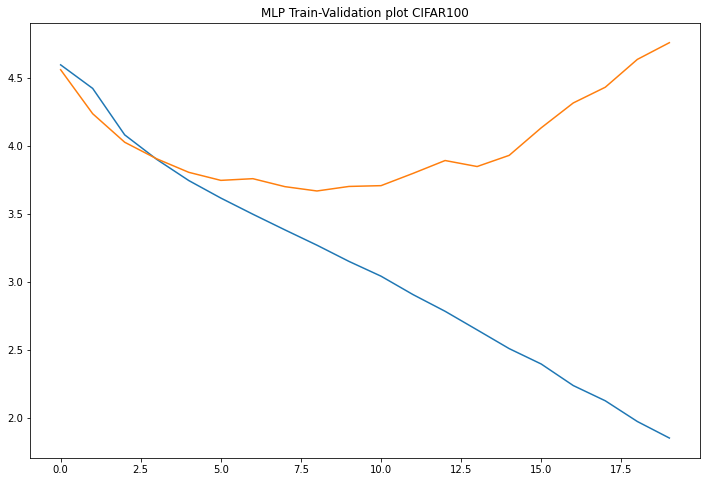

In [26]:
plt.figure(figsize=(12,8))
plt.plot(training_loss_history_)
plt.plot(validation_loss_history_)
plt.title("MLP Train-Validation plot CIFAR100")
plt.savefig("MLP Train-Validation plot CIFAR100.png")

In [27]:
mlp=MyMLP().to(device)
training_epochs=9
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(mlp.parameters(),lr=0.001, momentum=0.9)

In [28]:
start=time.time()

for epoch in range(training_epochs):
    #mlp.train()
    for X,y in tr100_loader:
        X=X.to(device)
        y=y.to(device)
        X=X.view(-1,3*32*32)
        
        opt.zero_grad()
        output=mlp(X) 
        #print(output)
        #print(y)
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
        training_loss+=cost.item()
        
print("Time :",time.time()-start)

Time : 61.348567724227905


In [29]:
ts100_loader=DataLoader(dataset=ts100,
                      batch_size=batch_size,
                      shuffle=False)

In [30]:
start=time.time()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in ts100_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images=images.view(-1,3*32*32)
        outputs = mlp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy :',(100 * correct / total))
print("Time :",time.time()-start)

Accuracy : 14.03
Time : 3.594985246658325
